<a href="https://colab.research.google.com/github/tan816/Signal-Reconstruction-ML/blob/main/notebooks_02_noise_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt

In [ ]:
# Ensure pandas is installed before importing wfdb
!pip install pandas==2.2.3
!pip install wfdb
import wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
records= ['100','101','102','103','104']

ecg_signals=[]
fs=None

for rec in records:
  record=wfdb.rdrecord(rec,pn_dir='mitdb')
  ecg=record.p_signal[:,0] #MLII Lead
  ecg_signals.append(ecg)
  fs=record.fs    #Same for all MIT-BIH records

In [ ]:

ecg=record.p_signal[:,0]
fs=record.fs

In [ ]:
fs=360
t=np.arange(len(ecg)/fs)

In [ ]:
#Baseline wander Signal
#Low frequency sinusoidal drift

def add_baseline_wander(signal,fs,amplitude_ratio=0.2,freq=0.2):
  A=amplitude_ratio*np.max(np.abs(signal)) #Computes Noise amplitude,scaled relative to signal strength and keeps noise realisitic instead of arbitrarily large
  bw=A*np.sin(2*np.pi*freq*np.arange(len(signal))/fs) #Generates a low freq sinusoids ,f=0.2Hz,np.arange->converts samples into time.
  return signal+bw,bw  #Returns noisy signal and pure baseline wander(used for analysis and plots)

In [ ]:
#Power line interfernce
def add_powerline_noise(signal,fs,freq=50,amplitude_ratio=0.05):
  A=amplitude_ratio*np.max(np.abs(signal))  #Again scale noise amplitude realistically.
  pli= A*np.sin(2*np.pi*freq*np.arange(len(signal))/fs) #Generates a 50Hz sinusoidal wave.
  return signal+pli,pli #noisy signal matches with the QRS complexes which is why notch filters exist.

In [ ]:
def bandpass_filter(signal, fs, lowcut, highcut, order=4): #Butterworth band pass filter.
    nyq = 0.5 * fs
    low = lowcut / nyq #Nyquist frequencies.
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band') #Nomralizing cutoff f for digital filter design.
    return filtfilt(b, a, signal) #Designs filter coefficients.->Zero phase filtering and no phase distortion(critical for EMG Morphology).


In [ ]:
#Adding EMG noise->High frequency chaos from muscle movements and Muscle Artifacts.
def add_emg_noise(signal,fs,amplitude_ratio=0.1):
  white_noise=np.random.randn(len(signal)) #Pure white gaussian noise.
  nyq=fs/2
  highcut=min(200,nyq-1) #ensuring valid range
  emg=bandpass_filter(white_noise,fs,20,highcut) #Filters noise into 20-150Hz,typical EMG Frequency band.
  emg=amplitude_ratio*np.max(np.abs(signal))*emg/np.max(np.abs(emg)) #Normalizes EMG Noise,scales it relative to signal amplitude
  return signal+emg,emg
  #This noise especially destroys P waves and T waves.

In [ ]:
#Adding AWGN Noises
#pure electronic randomness
def add_awgn(signal,snr_db):
  signal_power=np.mean(signal**2) #Average Signal Power
  noise_power=signal_power/(10**(snr_db/10)) #Converts SNR from dB into linear scale.
  noise=np.sqrt(noise_power)*np.random.randn(len(signal)) #Gaussian noise with calculated variance.
  return signal+noise,noise #This noise affects everything uniformily.


In [ ]:
def add_all_noises(signal,fs,snr_db=10):
  y,bw=add_baseline_wander(signal,fs)
  y,pli=add_powerline_noise(y,fs)
  y,emg=add_emg_noise(y,fs)
  y,awgn=add_awgn(y,snr_db)
  return y,bw,pli,emg,awgn
  #Stacking Low-f drift,Narrowband power noise,high frequency power noise,Broadband gaussian noise.

In [ ]:
noisy_ecgs=[]
noise_components=[]

for ecg in ecg_signals:
  ecg_noisy,bw,pli,emg,awgn=add_all_noises(ecg,fs,snr_db=10)
  noisy_ecgs.append(ecg_noisy)
  noise_components.append((bw,pli,emg,awgn))

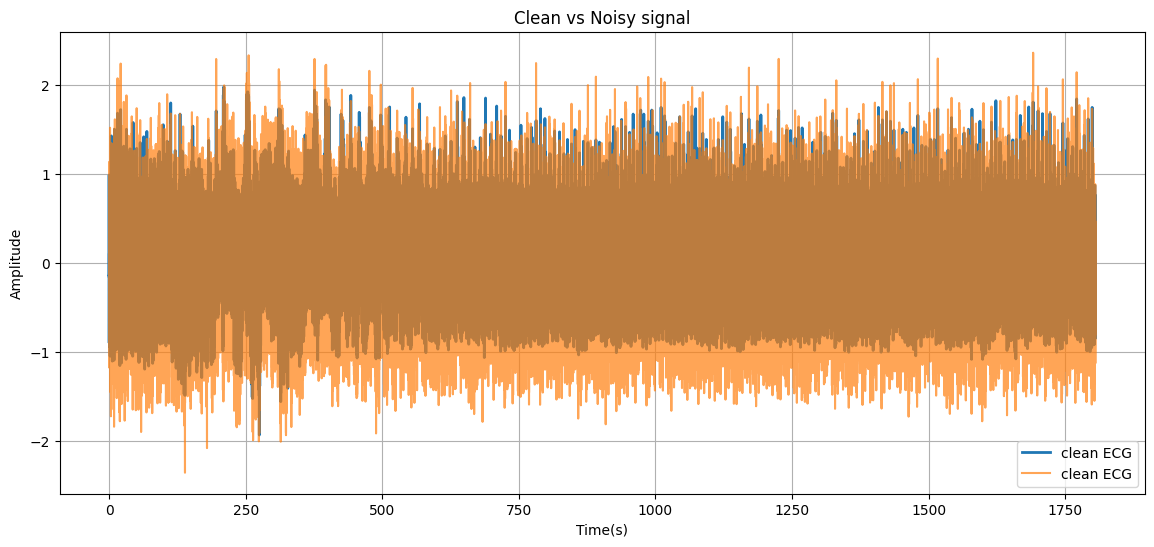

In [ ]:
#Visualization and plotting the graph
t = np.arange(len(ecg)) / fs # Recalculate t to match the length of ecg
plt.figure(figsize=(14,6))
plt.plot(t,ecg,label="clean ECG",linewidth=2)
plt.plot(t,ecg_noisy,label="clean ECG",alpha=0.7)
plt.legend()
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Clean vs Noisy signal")
plt.grid()
plt.show()

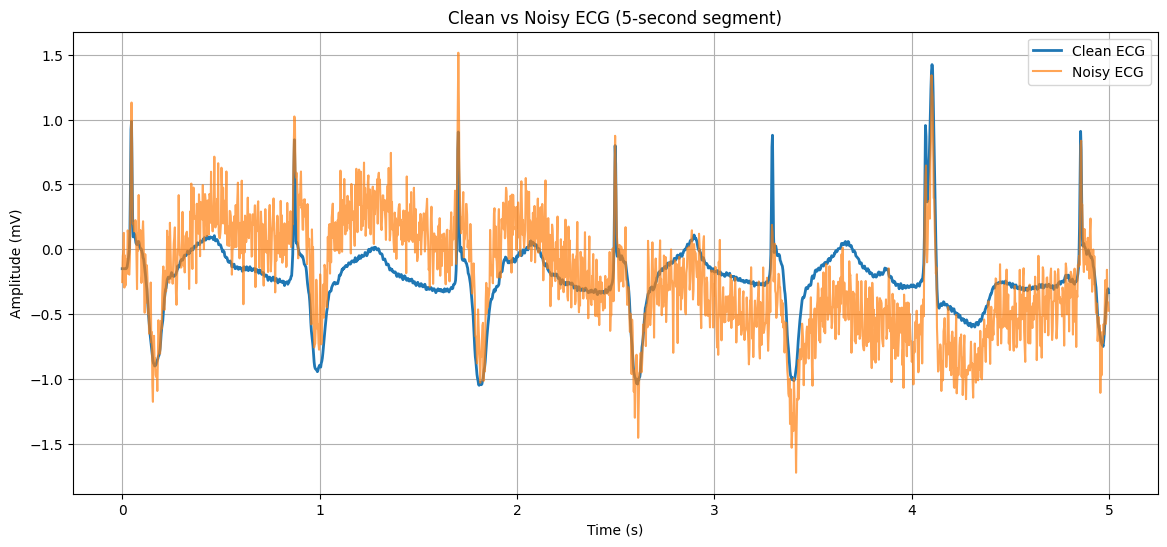

In [ ]:
start = 0
end = int(5 * fs)

plt.figure(figsize=(14,6))
plt.plot(t[start:end], ecg[start:end], label="Clean ECG", linewidth=2)
plt.plot(t[start:end], ecg_noisy[start:end], label="Noisy ECG", alpha=0.7)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.title("Clean vs Noisy ECG (5-second segment)")
plt.legend()
plt.grid()
plt.show()
